<a id="a1"></a>
# Import the necessary libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import requests
from io import StringIO

#setting up for customized printing
from IPython.display import Markdown, display
from IPython.display import HTML
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
#function to display dataframes side by side    
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)

In [4]:
def distplot(figRows,figCols,xSize, ySize, data, features, colors, kde=True, bins=None):
    f, axes = plt.subplots(figRows, figCols, figsize=(xSize, ySize))
    
    features = np.array(features).reshape(figRows, figCols)
    colors = np.array(colors).reshape(figRows, figCols)
    
    for row in range(figRows):
        for col in range(figCols):
            if (figRows == 1 and figCols == 1) :
                axesplt = axes
            elif (figRows == 1 and figCols > 1) :
                axesplt = axes[col]
            elif (figRows > 1 and figCols == 1) :
                axesplt = axes[row]
            else:
                axesplt = axes[row][col]
            plot = sns.distplot(data[features[row][col]], color=colors[row][col], bins=bins, ax=axesplt, kde=kde, hist_kws={"edgecolor":"k"})
            plot.set_xlabel(features[row][col],fontsize=20)

In [5]:
def scatterplot(rowFeature, colFeature, data):
    f, axes = plt.subplots(1, 1, figsize=(10, 8))
        
    plot=sns.scatterplot(x=rowFeature, y=colFeature, data=data, ax=axes)
    plot.set_xlabel(rowFeature,fontsize=20)
    plot.set_ylabel(colFeature,fontsize=20)

<a id="a2"></a>
# Read the data as a data frame

In [6]:
movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', delimiter='\t', names=['userId', 'movieId', 'Rating','timestamp'], header=None)
movies.head()

,userId,movieId,Rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


<a id="a4"></a>
# Perform basic EDA

<a id="a4a"></a>
## a. Drop 'timestamp' attribute

In [7]:
movies.drop('timestamp', axis=1, inplace=True)

<a id="a4b"></a>
## b. Create subset of the original dataset

**Filtering the users who has given 50 or more number of ratings**

In [8]:
movies_groupby_users_Ratings = movies.groupby('userId')['Rating']
movies_groupby_users_Ratings = pd.DataFrame(movies_groupby_users_Ratings.count())
user_list_min50_ratings = movies_groupby_users_Ratings[movies_groupby_users_Ratings['Rating'] >= 50].index
movies =  movies[movies['userId'].isin(user_list_min50_ratings)]

<a id="a4c"></a>
## c. Shape of the data

In [22]:
print('The total number of rows :', movies.shape[0])
print('The total number of columns :', movies.shape[1])

The total number of rows : 88471
The total number of columns : 3


<a id="a4d"></a>
## d. Data type of each attribute

In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88471 entries, 1 to 99999
Data columns (total 3 columns):
userId     88471 non-null int64
movieId    88471 non-null int64
Rating     88471 non-null int64
dtypes: int64(3)
memory usage: 2.7 MB


<a id="a4e"></a>
## e. Checking the presence of missing values

In [24]:
display(movies.isna().sum().sort_values())
print('===================')
printmd('**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data', color="blue")

userId     0
movieId    0
Rating     0
dtype: int64

<span style='color:blue'>**CONCLUSION**: As seen from the data above, we conclude there are **"No Missing"** values in the data</span>

<a id="a4f"></a>
## f. 5 point summary of numerical attributes

In [25]:
display(movies[['Rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Rating,88471.0,3.520193,1.124115,1.0,3.0,4.0,4.0,5.0


<a id="a4g"></a>
## g. Unique Users and Movies Count

In [26]:
print('Total unique users in the dataset', movies['userId'].nunique())
print('Total unique movies in the dataset', movies['movieId'].nunique())

Total unique users in the dataset 568
Total unique movies in the dataset 1681


<a id="a5"></a>
# Data Analysis and Visualization

<a id="a5a"></a>
## a. Rating Distribution

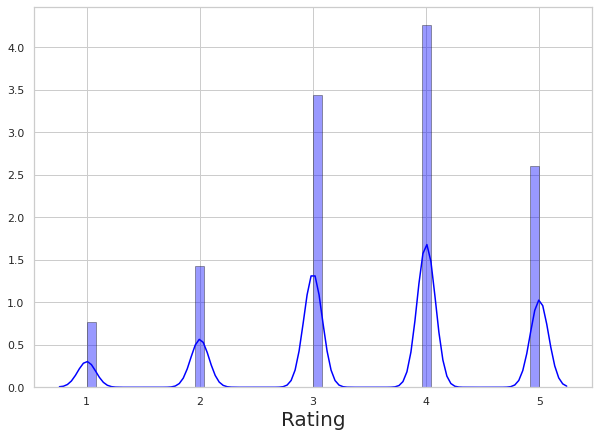

In [27]:
pal = sns.color_palette(palette='Set1', n_colors=16)
distplot(1, 1, 10, 7, data=movies, features=['Rating'], colors=['blue'])

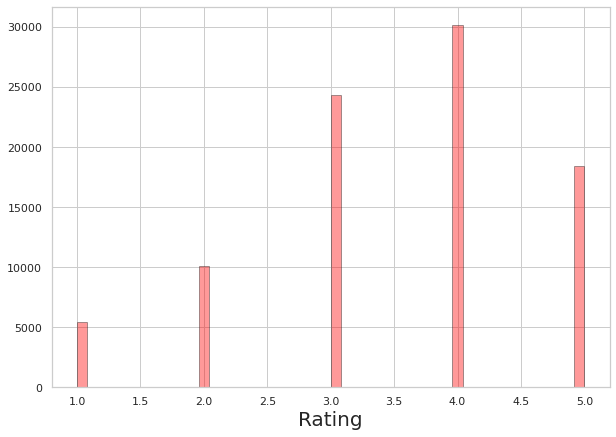

In [28]:
distplot(1, 1, 10, 7, data=movies, features=['Rating'], colors=['red'], kde=False)

<a id="a5b"></a>
## b. Top Rating Count Distribution grouped by Movies

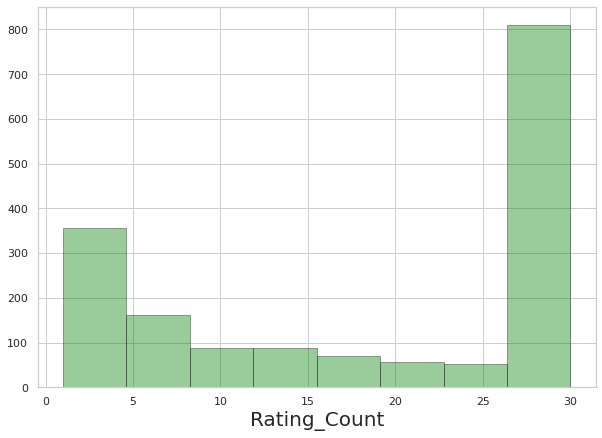

In [29]:
movies_groupby_movie_Ratings = movies.groupby('movieId')['Rating']
movies_groupby_movie_Ratings.count().clip(upper=30).unique()
ratings_movies = pd.DataFrame(movies_groupby_movie_Ratings.count().clip(upper=30))
ratings_movies.rename(columns={"Rating": "Rating_Count"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings_movies, features=['Rating_Count'], colors=['green'], kde=False)

<a id="a5c"></a>
## c. Top Rating Count Distribution grouped by Users

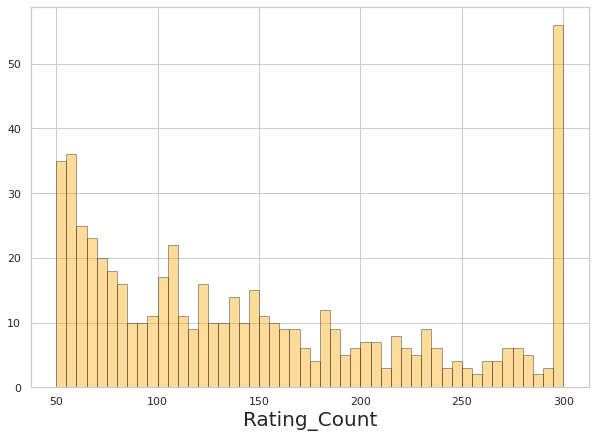

In [30]:
movies_groupby_users_Ratings = movies.groupby('userId')['Rating']
movies_groupby_users_Ratings.count().clip(lower=50).unique()
rating_users = pd.DataFrame(movies_groupby_users_Ratings.count().clip(lower=50, upper=300))
rating_users.rename(columns={"Rating": "Rating_Count"}, inplace=True)
distplot(1, 1, 10, 7, data=rating_users, features=['Rating_Count'], colors=['orange'], kde=False, bins=50)

<a id="a5d"></a>
## d. Mean Rating Distribution grouped by Movies

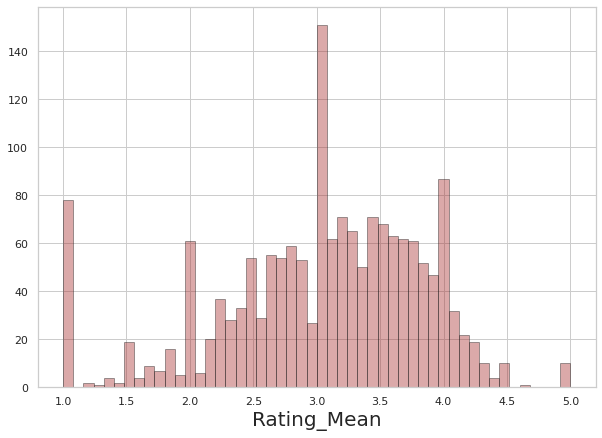

In [31]:
ratings = pd.DataFrame(movies.groupby('movieId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

<a id="a5e"></a>
## e. Mean Rating - Rating Count Distribution grouped by Movies

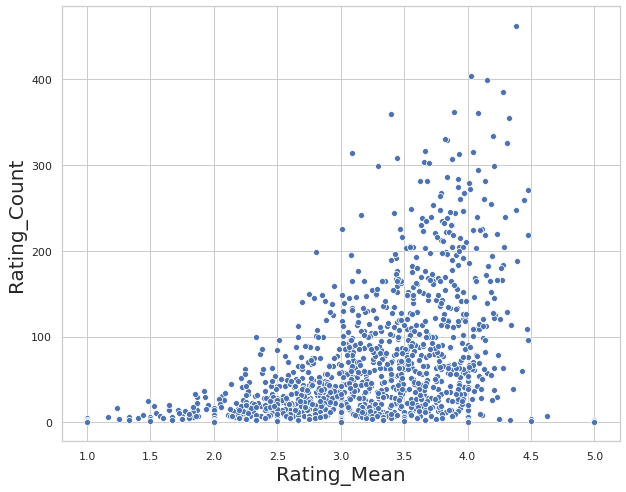

In [32]:
ratings['Rating_Count'] = movies.groupby('movieId')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

<a id="a5f"></a>
## f. Mean Rating Distribution grouped by Users

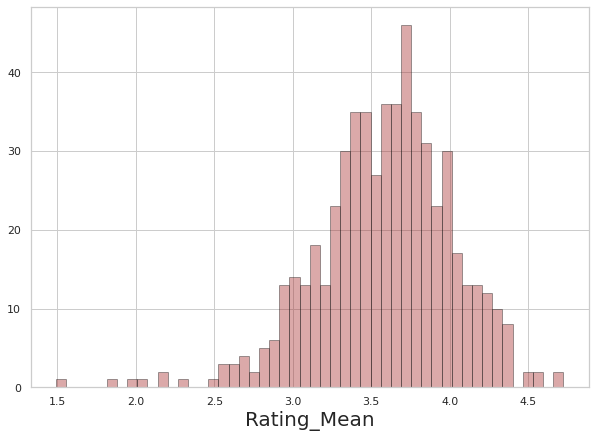

In [33]:
ratings = pd.DataFrame(movies.groupby('userId')['Rating'].mean())
ratings.rename(columns={"Rating": "Rating_Mean"}, inplace=True)
distplot(1, 1, 10, 7, data=ratings, features=['Rating_Mean'], colors=['brown'], kde=False, bins=50)

<a id="a5g"></a>
## g. Mean Rating - Rating Count Distribution grouped by Users

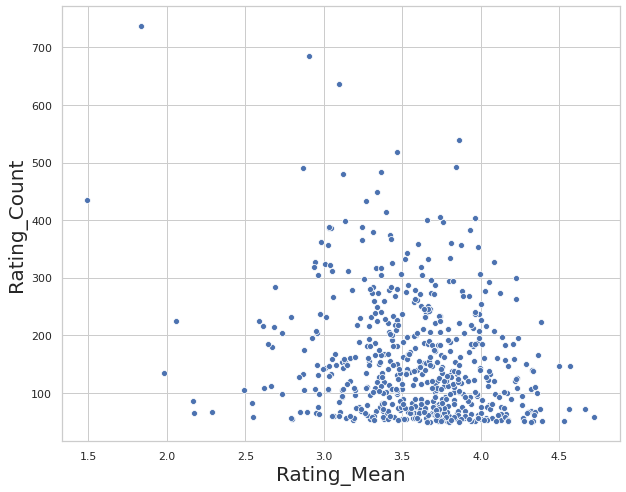

In [34]:
ratings['Rating_Count'] = movies.groupby('userId')['Rating'].count()
scatterplot('Rating_Mean', 'Rating_Count', data=ratings)

<a id="a6"></a>
# Split the data into training and test set in the ratio of 70:30 respectively

In [9]:
train_data, test_data = train_test_split(movies, test_size =.30, random_state=10)
printmd('**Training and Testing Set Distribution**', color='brown')

print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

<span style='color:brown'>**Training and Testing Set Distribution**</span>

Training set has 61929 rows and 3 columns
Testing set has 26542 rows and 3 columns


<a id="a7"></a>
# Recommender Systems

<a id="a7a"></a>
## a. Popularity Based Recommender Model

In [36]:
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(20)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id, n=5):    
        user_recommendations = self.popularity_recommendations
        
        #Filter products that are not rated by the user
        products_already_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]        
        user_recommendations = user_recommendations[~user_recommendations[self.item_id].isin(products_already_rated_by_user)]
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols].head(n)     
        self.plot(user_recommendations)
        return user_recommendations
    
    def plot(self, user_recommendations):
        f, axes = plt.subplots(1, 2, figsize=(20, 8))
        cplot1 = sns.barplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[0])
        cplot1.set_xlabel('Rank',fontsize=20)
        cplot1.set_ylabel('score',fontsize=20)            
        cplot2 = sns.pointplot(x='Rank', y='score', data=user_recommendations, hue='Rank', ax=axes[1])
        cplot2.set_xlabel('Rank',fontsize=20)
        cplot2.set_ylabel('score',fontsize=20)
        
    def predict_evaluate(self):        
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['Rating'].mean())
        
        pred_ratings = [];            
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)
        
        mse = mean_squared_error(self.test_data['Rating'], pred_ratings)
        rmse = sqrt(mse)
        return rmse

<a id="a7a1"></a>
### Initialize and Fit

In [37]:
pr = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id='userId', item_id='movieId')
pr.fit()

<a id="a7a3"></a>
### Recommend

,user_id,movieId,score,Rank
49,99,50,321,1.0
180,99,181,295,2.0
99,99,100,268,3.0
55,99,56,264,4.0
0,99,1,253,5.0
,user_id,movieId,score,Rank
49,198,50,321,1.0
180,198,181,295,2.0
99,198,100,268,3.0
55,198,56,264,4.0


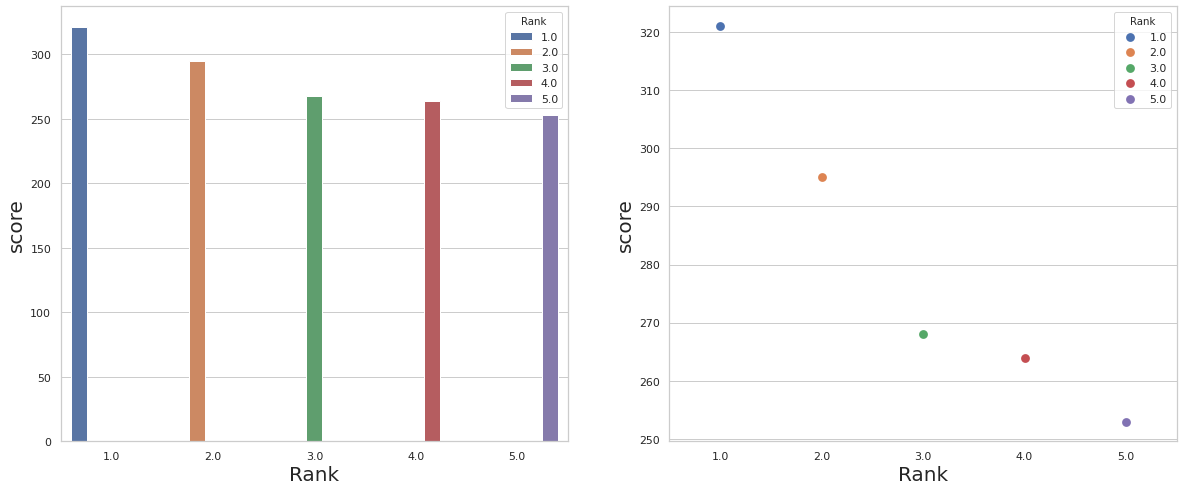

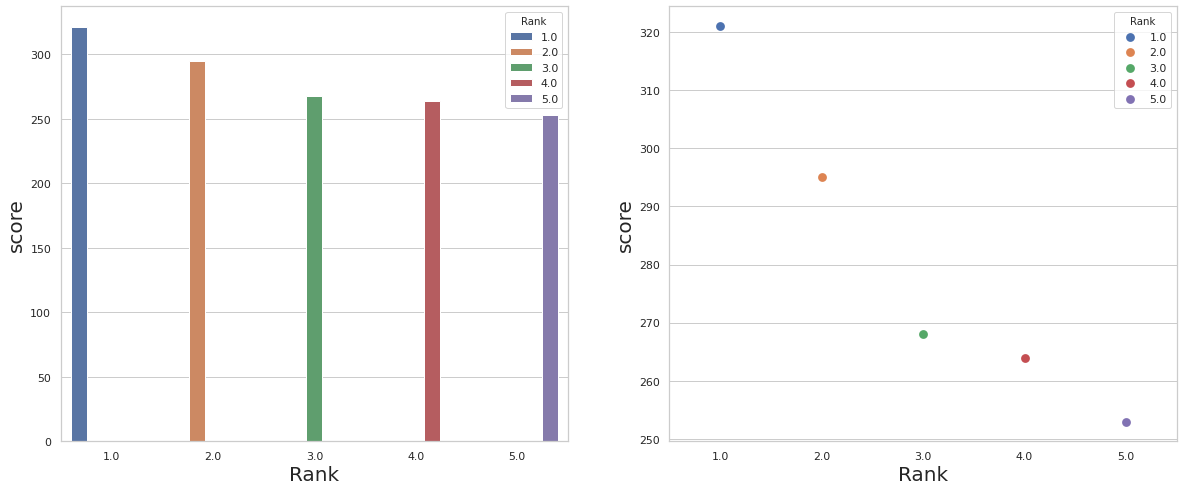

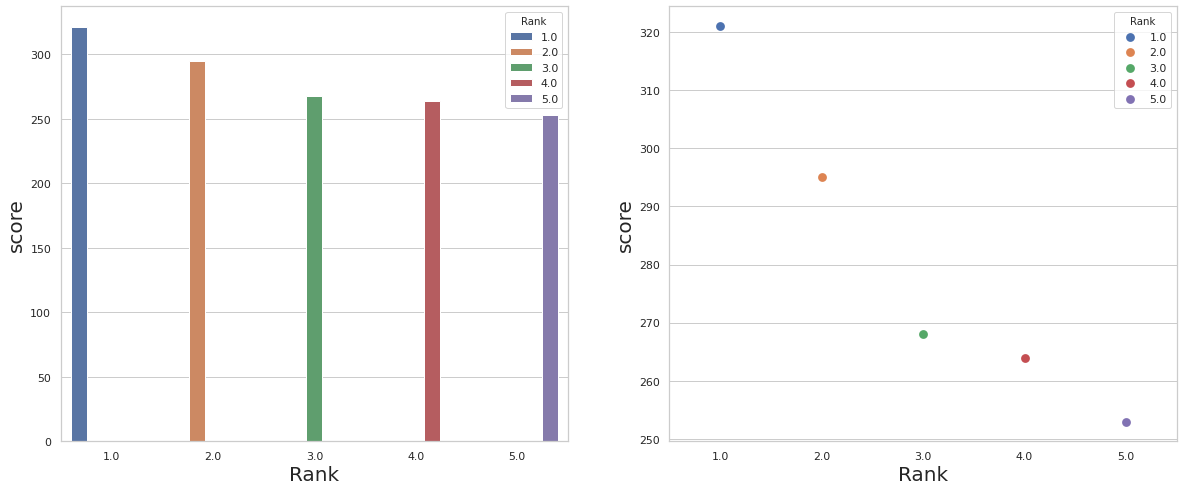

In [38]:
result_pop_user1 = pr.recommend('99')
result_pop_user2 = pr.recommend('198')
result_pop_user3 = pr.recommend('299')
display_side_by_side([result_pop_user1, result_pop_user2, result_pop_user3])

In [39]:
print("rmse value: " + str(pr.predict_evaluate()))

rmse value: 1.0232654282753917


<a id="a7b"></a>
## b. Collaborative Filtering Recommender Model using SURPRISE Library

<a id="a7b1"></a>
### Load Surprise Data from DataFrame

In [10]:
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans
reader = Reader()
surprise_data = Dataset.load_from_df(movies, reader)

<a id="a7b2"></a>
### Split the data into training and test set in the ratio of 70:30 respectively

In [11]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(surprise_data, test_size=.3, random_state=10)

In [12]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [13]:
class collab_filtering_based_recommender_model():
    def __init__(self, model, trainset, testset, data):
        self.model = model
        self.trainset = trainset
        self.testset = testset
        self.data = data
        self.pred_test = None
        self.recommendations = None
        self.top_n = None
        self.recommenddf = None

    def fit_and_predict(self):        
        printmd('**Fitting the train data...**', color='brown')
        self.model.fit(self.trainset)       

        printmd('**Predicting the test data...**', color='brown')
        self.pred_test = self.model.test(self.testset)        
        rmse = round(accuracy.rmse(self.pred_test), 3)
        printmd('**RMSE for the predicted result is ' + str(rmse) + '**', color='brown')   
        
        self.top_n = get_top_n(self.pred_test)
        self.recommenddf = pd.DataFrame(columns=['userId', 'movieId', 'Rating'])
        for item in self.top_n:
            subdf = pd.DataFrame(self.top_n[item], columns=['movieId', 'Rating'])
            subdf['userId'] = item
            cols = subdf.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            subdf = subdf[cols]    
            self.recommenddf = pd.concat([self.recommenddf, subdf], axis = 0)     
        return rmse
        
    def cross_validate(self):
        printmd('**Cross Validating the data...**', color='brown')
        cv_result = cross_validate(self.model, self.data, n_jobs=-1)
        cv_result = round(cv_result['test_rmse'].mean(),3)
        printmd('**Mean CV RMSE is ' + str(cv_result)  + '**', color='brown')
        return cv_result

    def recommend(self, user_id, n=5):
        df = self.recommenddf[self.recommenddf['userId'] == int(user_id)].head(n)
        return df

In [14]:
from surprise.model_selection import RandomizedSearchCV

def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

<a id="a7b3"></a>
### KNN With Means - Memory Based Collaborative Filtering

In [45]:
sim_options = {
    "name": ["msd", "cosine", "pearson"],
    "min_support": [2, 4, 8],
    "user_based": [True],
}
params = { 'k': [10, 20, 30], 'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.9363161676980454}
{'rmse': {'k': 30, 'sim_options': {'name': 'pearson', 'min_support': 8, 'user_based': True}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x780797c46d68>}


<a id="a7b3b"></a>
#### Initialize

In [46]:
knnwithmeans = clf.best_estimator['rmse']
col_fil_knnwithmeans = collab_filtering_based_recommender_model(knnwithmeans, trainset, testset, surprise_data)

<a id="a7b3c"></a>
#### Fit and Predict

In [47]:
knnwithmeans_rmse = col_fil_knnwithmeans.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

Computing the pearson similarity matrix...
Done computing similarity matrix.


<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.9385


<span style='color:brown'>**RMSE for the predicted result is 0.939**</span>

<a id="a7b3d"></a>
#### Cross Validate

In [60]:
knnwithmeans_cv_rmse = col_fil_knnwithmeans.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.937**</span>

<a id="a7b3e"></a>
#### Recommend

In [49]:
result_knn_user1 = col_fil_knnwithmeans.recommend(user_id='99', n=5)
result_knn_user2 = col_fil_knnwithmeans.recommend(user_id='198', n=5)
result_knn_user3 = col_fil_knnwithmeans.recommend(user_id='299', n=5)
display_side_by_side([result_knn_user1, result_knn_user2, result_knn_user3])

,userId,movieId,Rating
0,99,313,4.453927
1,99,246,4.276267
2,99,22,4.226257
3,99,124,4.199897
4,99,173,4.172640
,userId,movieId,Rating
0,198,654,4.134923
1,198,176,4.114065
2,198,357,4.094766
3,198,180,4.086006


<a id="a7b4"></a>
### SVD - Model Based Collaborative Filtering

In [15]:
params= {
    "n_epochs": [5, 10, 15, 20, 25, 30],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.2, 0.4, 0.6]
}
clf = find_best_model(SVD, params, surprise_data)

{'rmse': 0.932766652993491}
{'rmse': {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}}
{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7e0308c1ec18>}


<a id="a7b4b"></a>
#### Initialize

In [16]:
svd = clf.best_estimator['rmse']
col_fil_svd = collab_filtering_based_recommender_model(svd, trainset, testset, surprise_data)

<a id="a7b4c"></a>
#### Fit and Predict

In [17]:
svd_rmse = col_fil_svd.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.9309


<span style='color:brown'>**RMSE for the predicted result is 0.931**</span>

<a id="a7b4d"></a>
#### Cross Validate

In [18]:
svd_cv_rmse = col_fil_svd.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.932**</span>

<a id="a7b4e"></a>
#### Recommend

In [54]:
result_svd_user1 = col_fil_svd.recommend(user_id='99', n=5)
result_svd_user2 = col_fil_svd.recommend(user_id='198', n=5)
result_svd_user3 = col_fil_svd.recommend(user_id='299', n=5)
display_side_by_side([result_svd_user1, result_svd_user2, result_svd_user3])

,userId,movieId,Rating
0,99,313,4.213867
1,99,22,4.082447
2,99,173,4.065418
3,99,124,4.049032
4,99,181,4.036100
,userId,movieId,Rating
0,198,174,3.868669
1,198,427,3.868073
2,198,357,3.834912
3,198,498,3.820703


### Non-Negative Matrix Factorization model

In [55]:
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import NMF

params = {
    'n_factors': [8, 16, 32],
    'n_epochs': [10, 20, 30],
    'biased': [True, False]  # Whether to use biases or not
}

# Use GridSearchCV to find the best NMF model
clf = GridSearchCV(NMF, params, measures=['rmse'], cv=3, n_jobs=-1)
clf.fit(surprise_data)

# Get the best NMF model
best_nmf_model = clf.best_estimator['rmse']

In [56]:
col_fil_nmf = collab_filtering_based_recommender_model(best_nmf_model, trainset, testset, surprise_data)

In [57]:
nmf_rmse = col_fil_nmf.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.9291


<span style='color:brown'>**RMSE for the predicted result is 0.929**</span>

In [58]:
nmf_cv_rmse = col_fil_nmf.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.93**</span>

In [59]:
result_nmf_user1 = col_fil_nmf.recommend(user_id='99', n=5)
result_nmf_user2 = col_fil_nmf.recommend(user_id='198', n=5)
result_nmf_user3 = col_fil_nmf.recommend(user_id='299', n=5)
display_side_by_side([result_nmf_user1, result_nmf_user2, result_nmf_user3])

,userId,movieId,Rating
0,99,313,4.346964
1,99,173,4.317604
2,99,22,4.211845
3,99,181,4.151171
4,99,238,4.081391
,userId,movieId,Rating
0,198,357,3.934203
1,198,498,3.908046
2,198,191,3.891199
3,198,174,3.889502


### Neural Collaborative Filtering model

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from surprise import AlgoBase
from surprise import PredictionImpossible

class NeuralNetworkModel(AlgoBase):
    def __init__(self, hidden_layer_sizes=(16,), learning_rate=0.1, epochs=10, batch_size=32):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # Create the neural network model
        self.model = Sequential()
        self.model.add(Dense(self.hidden_layer_sizes[0], input_dim=2, activation='relu'))

        for layer_size in self.hidden_layer_sizes[1:]:
            self.model.add(Dense(layer_size, activation='relu'))

        self.model.add(Dense(1))
        print(self.model.summary())

        # Compile the model
        self.model.compile(optimizer=Adam(lr=self.learning_rate), loss='mean_squared_error')

        # Prepare data
        X = np.zeros((trainset.n_ratings, 2))
        y = np.zeros(trainset.n_ratings)

        for idx,(u, i, r) in enumerate(trainset.all_ratings()):
            X[idx, 0] = u
            X[idx, 1] = i
            y[idx] = r

        # Fit the model
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

    def test(self, testset):
        # Get the testset in the required format
        X_test = np.zeros((len(testset),2))
        y_true = np.zeros(len(testset))

        predictions = []
        for idx, (uid, iid, rating) in enumerate(testset):
            X_test[idx,0] = uid
            X_test[idx,1] = iid
            y_true[idx] = rating
            predictions.append([uid,iid,rating,0.0,0.0])

        # Predict ratings
        y_pred = self.model.predict(X_test)
        for i,rating in enumerate(y_pred):
            predictions[i][3]=rating[0]
        return predictions

In [ ]:
params= {
    "hidden_layer_sizes":[(10,5),(500,100)],
    "learning_rate":[0.01,0.1,0.001],
    "epochs":[100,50,200],
    "batch_size":[64,32,128]
}
clf = find_best_model(NeuralNetworkModel, params, surprise_data)

In [ ]:
nn = clf.best_estimator['rmse']
col_fil_nn = collab_filtering_based_recommender_model(nn, trainset, testset, surprise_data)

In [19]:
nn_rmse = col_fil_nn.fit_and_predict()

<span style='color:brown'>**Fitting the train data...**</span>

<span style='color:brown'>**Predicting the test data...**</span>

RMSE: 0.8936


<span style='color:brown'>**RMSE for the predicted result is 0.894**</span>

In [20]:
nn_cv_rmse = col_fil_nn.cross_validate()

<span style='color:brown'>**Cross Validating the data...**</span>

<span style='color:brown'>**Mean CV RMSE is 0.895**</span>

In [ ]:
result_nn_user1 = col_fil_nn.recommend(user_id='99', n=5)
result_nn_user2 = col_fil_nn.recommend(user_id='198', n=5)
result_nn_user3 = col_fil_nn.recommend(user_id='299', n=5)
display_side_by_side([result_nn_user1, result_nn_user2, result_nn_user3])

# plot comparison

In [62]:
import matplotlib.pyplot as plt

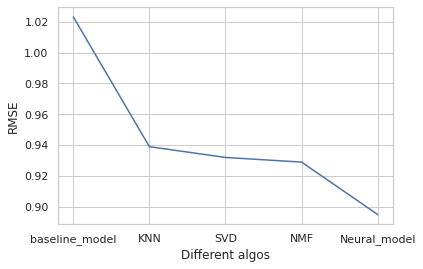

In [65]:
rmses = [1.0232, .939, .932, .929, .895]
algos = ['baseline_model', 'KNN', "SVD", 'NMF', 'Neural_model']
plt.plot(algos, rmses)
plt.xlabel("Different algos")
plt.ylabel("RMSE")
plt.show()